# Memo on Clustering and Topic Modelling

Yuxiao Sun, 455136

Abstract: I build a database of large Nonprofits (definition here: http://www.charitynavigator.org/index.cfm?bay=content.view&cpid=32#.VxovOyb8s8o) by web-scraping all the NGOs rated by the CharityNavigator. The database contains basic information about the Nonprofits: sector, location, ratings, mission statements, etc. After that, I apply clustering method (mainly the K-mean method with tf-idf normalization) to classify a training set into 25 clusters--to somehow echo the "official" classfication schema of Nonprofits (NTEE code: http://nccs.urban.org/classification/ntee.cfm). As for evaluation, I plot a stacked bar graph showing the relationship between NTEE classification and my training results. I also run a chi-squared test of contingency confirming the significant relationship between my clustering result and the NTEE classification. However, since the relationship is not explicit, more works will be done to interpret it in the future. I will also test on different clustering methods to come up with the "best" classifier. One application of this is to classify nonprofits that are not officially (from IRS) classified by NTEE based on their mission statements. The unclassified nonprofits amount to 18.32% in our dataset of "large" and presumably famous nonprofits in US, so the proportion can be even higher for the complete space of 1.5 million nonprofits recorded by IRS.

In [1]:
import re
from urllib.request import urlopen
from urllib.request import Request
from bs4 import BeautifulSoup
import csv
import pandas as pd
import time
import datetime
import numpy as np
import os
import string
import nltk
from nltk.corpus import stopwords
import random
%matplotlib inline

# Part I Web Scraping

1.Landing Page

In [ ]:
letters = list(string.ascii_uppercase)

In [ ]:
digits=['1','2','3','4','5','9']

In [ ]:
pagenumber=letters+digits

In [ ]:
template = 'http://www.charitynavigator.org/index.cfm?bay=search.alpha&ltr={}'
pagelinks = [template.format(x) for x in pagenumber]

In [ ]:
for links,numbers in zip(pagelinks,pagenumber):
    filename = 'ngo_{}.htm'.format(numbers)
    html = urlopen(links).read().decode('utf-8') 
    out_dir='ngo'
    os.makedirs(out_dir,exist_ok=True)
    with open(out_dir + "/" + filename, 'w',encoding='utf-8') as f:
        f.write(html)

In [ ]:
name=[]
link=[]
location=[]
for page in pagenumber:
    filename='ngo_{}.htm'.format(page)
    html=open('ngo'+'/'+filename,'r',encoding='utf-8').read()
    soup=BeautifulSoup(html, "lxml")
    for each in soup.find('div',attrs={'id':'maincontent'}).find_all('a', href=re.compile('.*orgid=\d+')):
        try:
            nam=each.get_text().split(' - ')[-2]
        except:
            tit=None
        try:
            lin = each['href'] 
        except:
            lin=None        
        try:
            loc=each.get_text().split(' - ')[-1]
        except:
            loc=None
        
        name.append(nam) #append the list for each iteration
        link.append(lin)       
        location.append(loc)

In [ ]:
def format_filename(s):
#Take a string and return a valid filename constructed from the string. 
#Uses a whitelist approach: any characters not present in valid_chars are removed. 
    valid_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
    filename = ''.join(c for c in s if c in valid_chars)
    return filename

2.Summary Page

In [ ]:
ein=[]
n=0
for linkk,locationn,namee in zip(link,location,name): 
    try:    
        html = urlopen(linkk).read().decode('utf-8') 
    except:
        html=None
    try:
        e=BeautifulSoup(html,'lxml').find('div',attrs={'class':'tabs'}).find('a',href=re.compile('.*ein=\d+'))['href']
        ei=re.findall('\d+', e)
    except:
        ei=['0']
    fname=' '.join([str(n), str(ei)])
    filename = '{}.htm'.format(fname)
    out_dir='ngodetail'
    os.makedirs(out_dir,exist_ok=True)
    with open(out_dir + "/" + filename, 'w',encoding='utf-8') as f:
        f.write(html)
    ein=ein+ei
    n=n+1

In [ ]:
df=pd.DataFrame({'name':name,'link':link,'location':location,'ein':ein}) 

In [ ]:
df.to_csv('ngoein.csv',encoding='utf-8')

In [ ]:
df=pd.read_csv('ngoein.csv',encoding="ISO-8859-1")

In [ ]:
df['ein']

3.IRS Page

In [ ]:
template2 = 'http://www.charitynavigator.org/index.cfm?bay=search.irs&ein={}'
pagelinks2 = [template2.format(x) for x in df['ein']]

In [ ]:
n=0
for links,numbers in zip(pagelinks2,df['ein']):
    fname=' '.join([str(n), str(numbers)])
    filename = '{}.htm'.format(fname)
    try:
        html = urlopen(links).read().decode('utf-8')
    except:
        html = 'No data'
    out_dir='ngoirs'
    os.makedirs(out_dir,exist_ok=True)
    with open(out_dir + "/" + filename, 'w',encoding='utf-8') as f:
        f.write(html)
    n=n+1

# Part II Information Extraction

1.IRS Information Table

In [ ]:
os.getcwd()

In [ ]:
path = "ngoirs/"
dirs = os.listdir(path)

In [ ]:
ordered_files = sorted(dirs, key=lambda x: (int(re.sub('\s\d+.htm','',x)),x))

In [ ]:
ordered_files

In [ ]:
items=['EIN','Name in IRS Master File','NTEE Code','NTEE Classification','NTEE Type','Classification','Subsection','Activities',
      'Foundation Status','Deductibility','Affiliation','Group Name','Ruling Date','Filing Requirement','Fiscal Year End']

In [ ]:
col = [[] for i in range(15)]

In [ ]:
for each in ordered_files:
    with open('ngoirs/'+each, encoding='utf-8') as f:
        html=f.read()
        soup=BeautifulSoup(html,'lxml')
        table=soup.find('div', attrs={'class':'shadedtable'})
        for n in range(15):
            if table.find('td', text = re.compile(items[n])) != None:
                try:
                    value=table.find('td', text = re.compile(items[n])).findNext('td').get_text()
                except:
                    value='0'
            col[n].append(value)
df = pd.DataFrame(col).transpose()
df.columns=items
df.to_csv('ngoirs.csv')

In [ ]:
df

2.Rating Information Table

delete 312 donor advisory orgs

In [ ]:
path = "ngodetail/"
dirs = os.listdir(path)
ordered_files = sorted(dirs, key=lambda x: (int(re.sub('\s\[\'\d+\'\].htm','',x)),x))

In [ ]:
items=['Overall','Financial','Transparency','EIN']
col = [[] for i in range(4)]

In [ ]:
for each in ordered_files:
    with open('ngodetail/'+each, encoding='utf-8') as f:
        html=f.read()
        soup=BeautifulSoup(html,'lxml')
        table=soup.find('div', attrs={'class':'summaryBox'})
        lefttable=soup.find('div', attrs={'id':'leftnavcontent'})
        for n in range(3):
            if table.find('td', text = re.compile(items[n])) != None:
                try:
                    value=table.find('td', text = re.compile(items[n])).findNext('td').get_text()
                except:
                    value='0'
            col[n].append(value)
        col[3].append(str(lefttable.find(text=re.compile('\d{2}\-\d{7}'))).replace('\n','').replace('\t','').split(' ')[1])
df2 = pd.DataFrame(col).transpose()
df2.columns=items
df2

In [ ]:
df2.to_csv('ngorating.csv')

In [ ]:
df12 = df.merge(df2, left_on='EIN', right_on='EIN', how='inner')

3.Contact Information Table

In [2]:
path = "ngodetail/"
dirs = os.listdir(path)
ordered_files = sorted(dirs, key=lambda x: (int(re.sub('\s\[\'\d+\'\].htm','',x)),x))

In [5]:
city=[]
state=[]
tel=[]
street=[]
EIN=[]
website=[]
fax=[]

In [46]:
with open('contact.csv', 'w',encoding='utf-8') as file:
    writer = csv.writer(file, lineterminator = '\n')
    writer.writerow(['street','city','state','EIN','tel','fax','website'])
    for each in ordered_files[800:850]:
        with open('ngodetail/'+each, encoding='utf-8') as f:
            html=f.read()
            soup=BeautifulSoup(html,'lxml')
            lefttable=soup.find('div', attrs={'id':'leftnavcontent'})

            street=lefttable.find('br').nextSibling.replace('\n','').replace('\t','')
            EIN=str(lefttable.find(text=re.compile('\d{2}\-\d{7}'))).replace('\n','').replace('\t','').split(' ')[1]
            try:
                website=lefttable.find('a', attrs={'id':'orgSiteLink'})['href']
            except:
                website='NaN'
            try:
                tel=lefttable.find(text=re.compile('tel:')).replace('\n','').replace('\t','').replace('\xa0',' ')
            except:
                tel='NaN'
            try:
                fax=lefttable.find(text=re.compile('fax:')).replace('\n','').replace('\t','').replace('\xa0',' ')
            except:
                fax='NaN'
            try: 
                data=lefttable.find(text=re.compile('[A-Z]{2}(\s|&nbsp;)\d{5}')).replace('\n','').replace('\t','').replace('\xa0',' ').split(',')
            except:
                data=['NaN']
            city=data[0]
            state=data[-1]
            writer.writerow([street,city,state,EIN,tel,fax,website])

In [ ]:
df3=pd.read_csv('contact.csv')

In [ ]:
df123= df3.merge(df12, left_on='EIN', right_on='EIN', how='inner')

In [ ]:
df123.to_csv('ngoall.csv')

Mission Statement

In [ ]:
new=list(df[['Name in IRS Master File','EIN']].apply(lambda x: '_'.join(x), axis=1))

In [ ]:
for each,n in zip(ordered_files,new):
    with open('ngodetail/'+each, encoding='utf-8') as f:
        html=f.read()
        soup=BeautifulSoup(html,'lxml')
        divs = soup.findAll('div', attrs={'class' : 'summaryBox'})
        for div in divs:
            if div.find('a',text='Mission') is not None:
                mission=div.get_text()[9:]
            else:
                continue
            out_dir='ngomission'
            os.makedirs(out_dir,exist_ok=True)
            name = '{}.txt'.format(n)
            with open(out_dir + "/" + name, 'w',encoding='utf-8') as file:
                file.write(mission)   

# Part III Mission Statements Analysis

1.Setup

In [2]:
df=pd.read_csv('ngoall.csv')

In [128]:
df[:10]

,EIN,Name in IRS Master File,NTEE Code,NTEE Type (26),NTEE Classification,Affiliation,Founded,Overall,Financial Socre,Transparency Score,Tel,Website,Street,City,State,Zip
0,99-0226111,Aha Punana Leo,A70,"Arts, Culture and Humanities",Humanities Organizations,Independent,"March, 1984",80.96,77.00,86,tel: (808) 935-4304,http://www.ahapunanaleo.org/,96 Pu'uhonu Place,Hilo,HI,96720
1,23-7173492,A Better Chance Inc,[Not Provided by IRS],[Not Provided by IRS],[Not Provided by IRS],Independent,"May, 1972",86.39,80.76,100,tel: (646) 346-1310,http://www.abetterchance.org,253 West 35th Street,New York,NY,10001
2,73-1116884,A Chance To Change Foundation,[Not Provided by IRS],[Not Provided by IRS],[Not Provided by IRS],Central,"November, 1981",76.67,81.05,73,tel: (405) 840-9000,http://www.achancetochange.org/,5228 Classen Circle,Oklahoma City,OK,73118
3,58-1911741,A Childs Place Of Charlotte Inc,B90,Educational Institutions and Related Activities,Educational Services and Schools - Other,Independent,"April, 1991",90.69,87.46,96,tel: (704) 343-3790,http://www.achildsplace.org/,601 East Fifth Street,Charlotte,NC,28202
4,91-0787792,A Contemporary Theatre Inc,A65,"Arts, Culture and Humanities",Theater,Independent,"December, 1965",78.54,70.73,92,tel: (206) 292-7660,http://www.acttheatre.org,Kreielsheimer Place,Seattle,WA,98101
5,90-0018359,A Jewish Voice For Peace Inc,Q40,"International, Foreign Affairs and National Se...",International Peace and Security,Independent,"February, 2003",87.82,86.75,89,tel: (510) 465-1777,https://jewishvoiceforpeace.org,1611 Telegraph Avenue,Oakland,CA,94612
6,31-1440073,A Kid Again Inc,P58,Human Services - Multipurpose and Other,Gift Distribution,Independent,"September, 1995",81.89,74.39,100,tel: (800) 543-9735,http://www.akidagain.org,777-G Dearborn Park Lane,Columbus,OH,43085
7,26-0295572,Pediatric Low Grade Astrocytomafoundation Inc,T30,"Philanthropy, Voluntarism and Grantmaking Foun...",Public Foundations,Independent,"August, 2007",76.43,75.89,77,tel: (914) 762-3494,http://akidsbraintumorcure.org/,98 Random Farms Drive,Chappaqua,NY,10514
8,95-4443878,A Noise Within,A60,"Arts, Culture and Humanities",Performing Arts Organizations,Independent,"September, 1993",82.65,85.81,80,tel: (626) 356-3100,http://www.anoisewithin.org,3352 East Foothill Boulevard,Pasadena,CA,91107
9,95-4427291,A Place Called Home,Z99,Unknown,Unknown,Independent,"July, 1993",94.72,92.54,100,tel: (323) 232-7653,http://www.apch.org,2830 South Central Avenue,Los Angeles,CA,90011


In [62]:
#display the sectorial distribution of NGOs
df.groupby(['NTEE Type (26)'])['EIN'].count()

NTEE Type (26)
Animal-Related                                            389
Arts, Culture and Humanities                             1059
Civil Rights, Social Action, Advocacy                     108
Community Improvement, Capacity Building                   93
Crime, Legal-Related                                      113
Diseases, Disorders, Medical Disciplines                  150
Educational Institutions and Related Activities           626
Employment, Job-Related                                    54
Environmental Quality, Protection and Beautification      338
Food, Agriculture and Nutrition                           196
Health - General and Rehabilitative                       287
Housing, Shelter                                          218
Human Services - Multipurpose and Other                   882
International, Foreign Affairs and National Security      527
Medical Research                                           86
Mental Health, Crisis Intervention                     

For evaluation purpose later, I split the dataset into training and testing. The training dataset contains Nonprofits already classified by IRS, so we can check the relationship between our clustering method and IRS classification later.

In [70]:
dftest=df.loc[df['NTEE Type (26)'] == '[Not Provided by IRS]']
len(dftest)

1502

In [77]:
dftrain1=df.loc[df['NTEE Type (26)'] != '[Not Provided by IRS]']
dftrain=dftrain1.loc[dftrain1['NTEE Type (26)'] != 'Unknown']
len(dftrain)

6613

In [78]:
titles=list(dftrain[['Name in IRS Master File','EIN']].apply(lambda x: '_'.join(x), axis=1))

In [79]:
missions=[]
for title in titles:
    with open('ngomission/'+title+'.txt', encoding='utf-8') as f:
        txt=f.read()
        missions.append(txt)        

In [80]:
stopwords = nltk.corpus.stopwords.words('english')

In [81]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [82]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [83]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in missions:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'missions', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Create a reference table with the stemmed vocabulary as the index and the tokenized words as the column. Because stems to tokens are one to many, I choose to return the first token associated with the stem I need to look up.

In [95]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

2.TF-IDF

Here, I convert the missions list into a tf-idf matrix.

To get a Tf-idf matrix, first count word occurrences by document. Then apply the term frequency-inverse document frequency weighting.

The parameters I choose to get tf-idf:

max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably caries little meanining.

min_idf: I pass 0.2; the term must be in at least 20% of the document. 

ngram_range: I'll look at unigrams, bigrams and trigrams.

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(missions) #fit the vectorizer to missions
print(tfidf_matrix.shape)

CPU times: user 42.4 s, sys: 80 ms, total: 42.5 s
Wall time: 42.5 s
(6613, 18)


In [97]:
terms = tfidf_vectorizer.get_feature_names()

3.K-Means Clustering

Using the tf-idf matrix, we can run a slew of clustering algorithms to better understand the hidden structure within the missions statements. I first chose k-means. Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

In [98]:
from sklearn.cluster import KMeans
num_clusters = 25
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 7.05 s, sys: 0 ns, total: 7.05 s
Wall time: 7.06 s


In [101]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #10 words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: b'needs', b'community', b'provides', b'services', b'people', b'works', b'programs', b'supportive', b'mission', b'family',

Cluster 1 words: b'mission', b"'s", b'educational', b'provides', b'community', b'programs', b'needs', b'people', b'serving', b'children',

Cluster 2 words: b'educational', b'programs', b'community', b'provides', b'mission', b"'s", b'supportive', b'works', b'organization', b'serving',

Cluster 3 words: b"'s", b'organization', b'works', b'educational', b'people', b'mission', b'community', b'programs', b'serving', b'supportive',

Cluster 4 words: b'people', b"'s", b'educational', b'community', b'provides', b'mission', b'programs', b'works', b'living', b'organization',

Cluster 5 words: b'children', b"'s", b'provides', b'programs', b'educational', b'living', b'mission', b'supportive', b'help', b'needs',

Cluster 6 words: b'children', b'family', b'provides', b"'s", b'programs', b'services', b'living', b'supportive', b'serving', b

Note: the "word" s come's from the 's expression 

4.Evaluation

In [104]:
NGOmissions = { 'title': titles, 'missions': missions, 'cluster': clusters}
frame = pd.DataFrame(NGOmissions, index = [clusters] , columns = ['title', 'cluster', 'missions'])

In [105]:
ein=list(frame['title'].apply(lambda x: pd.Series(x.split('_')))[1])

In [106]:
NGOmissions2 = { 'title': titles, 'missions': missions, 'cluster': clusters,'EIN':ein}
frame2 = pd.DataFrame(NGOmissions2, index = [clusters] , columns = ['title', 'cluster', 'missions','EIN'])

In [107]:
ngoms= df.merge(frame2, left_on='EIN', right_on='EIN', how='inner')

In [119]:
ngo_by_typecluster= ngoms.groupby(['NTEE Type (26)','cluster'])
ngo_by_typecluster_count = ngo_by_typecluster['EIN'].count().unstack('NTEE Type (26)')

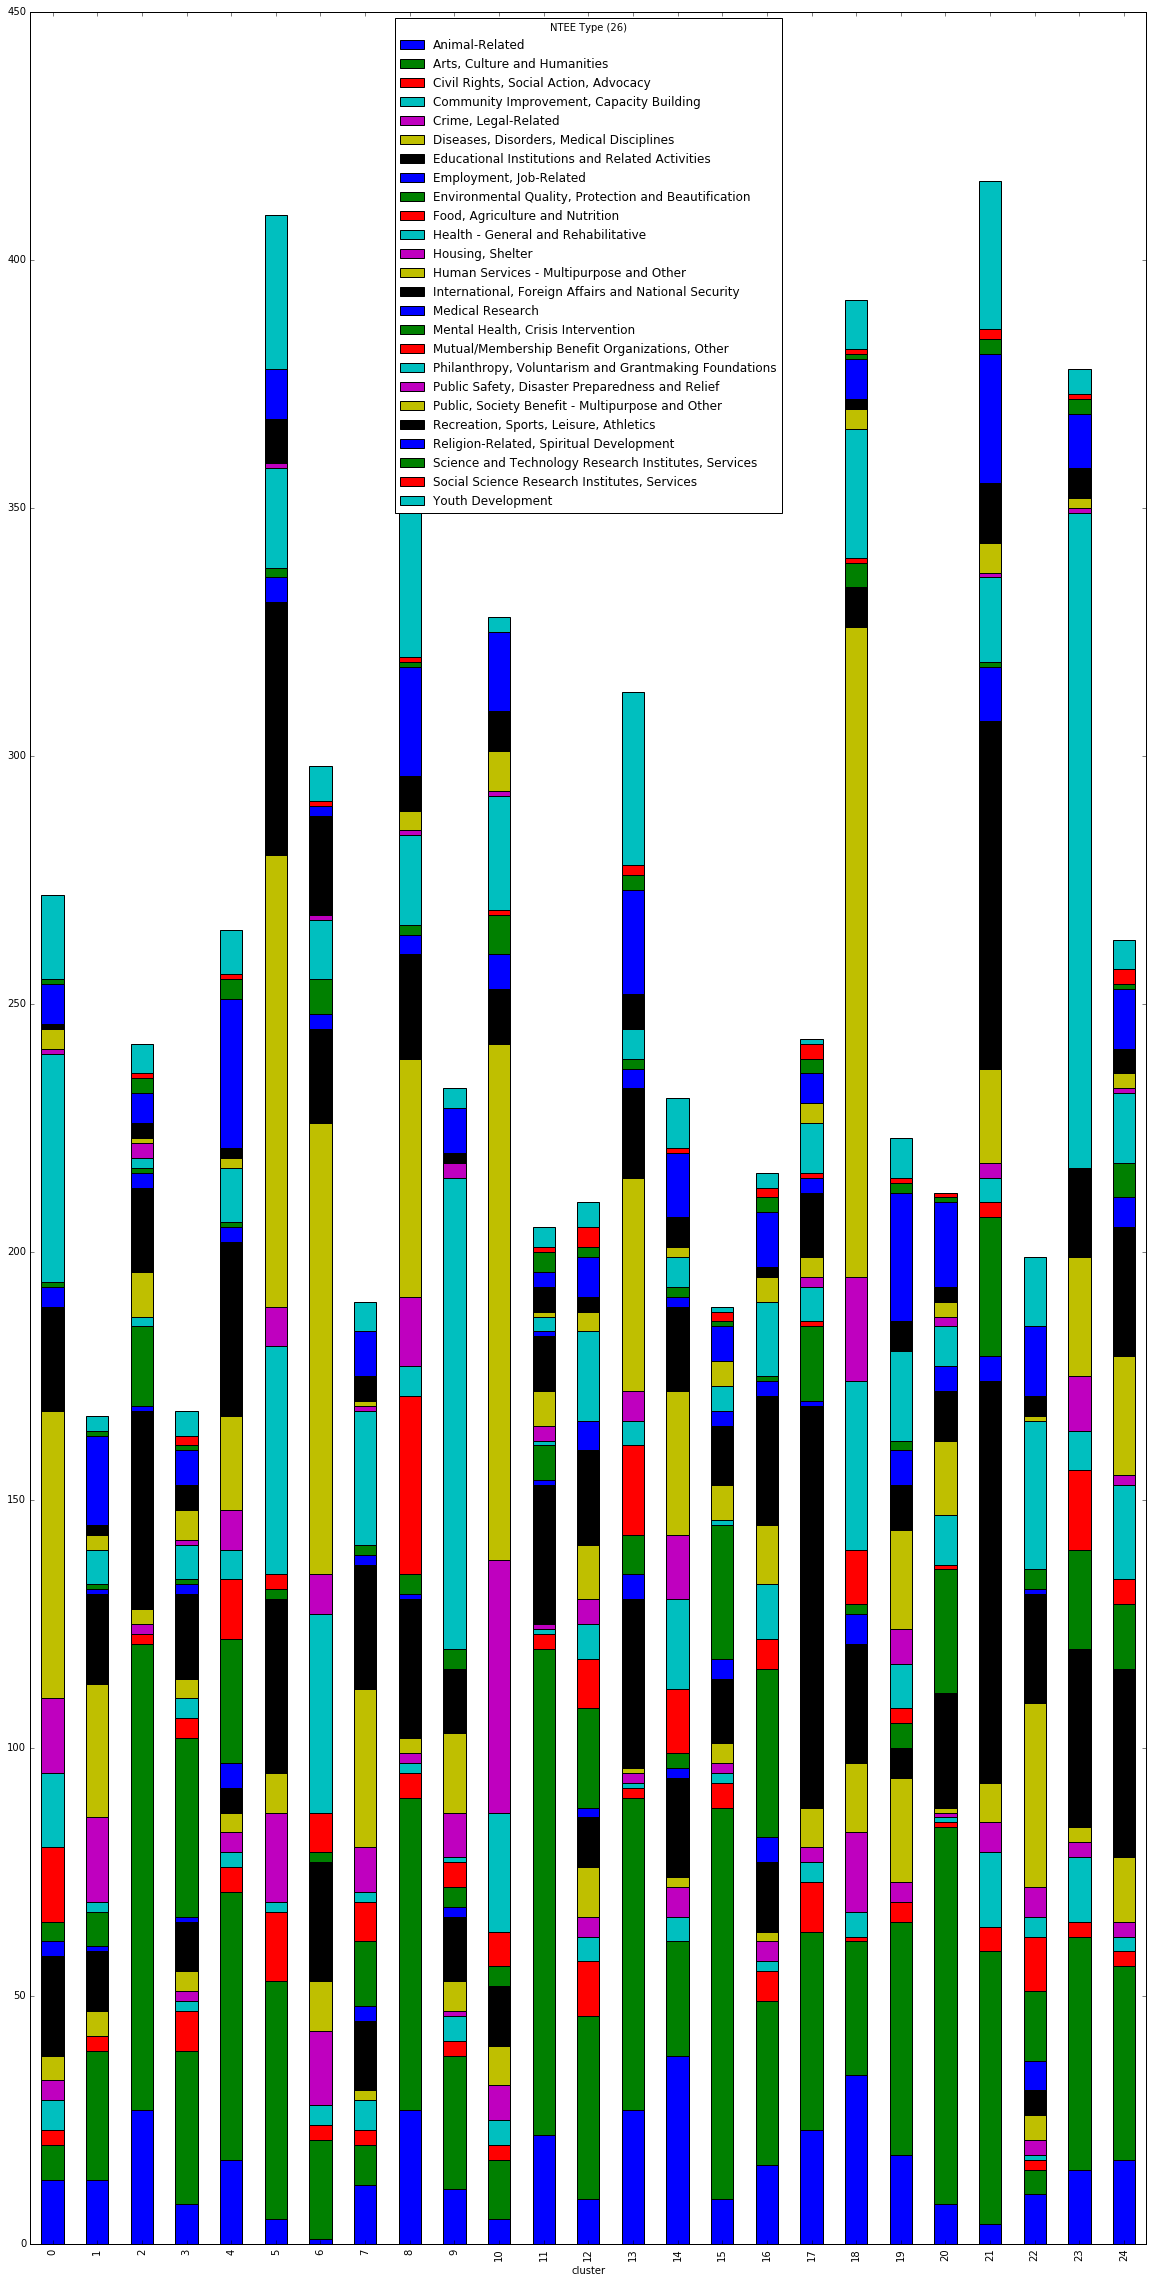

In [120]:
ngo_by_typecluster_count.plot.bar(stacked=True, figsize=(20,40))

To further extract the relationship between Kmean clustering and the IRS classification, I run a chi-square test of contingency. 

In [125]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex =chi2_contingency(pd.crosstab(ngoms['NTEE Type (26)'], ngoms['cluster']))

In [126]:
(chi2, p) 

(4114.5838435464484, 0.0)

To conclude, there is a significant relationship between our clustering result and the IRS classfication of Nonprofits, although that relationship is less explict and this is the topic for further research

5.Application to the Testing Dataset

Future application